KeyError: 'Column not found: abnormal_return'

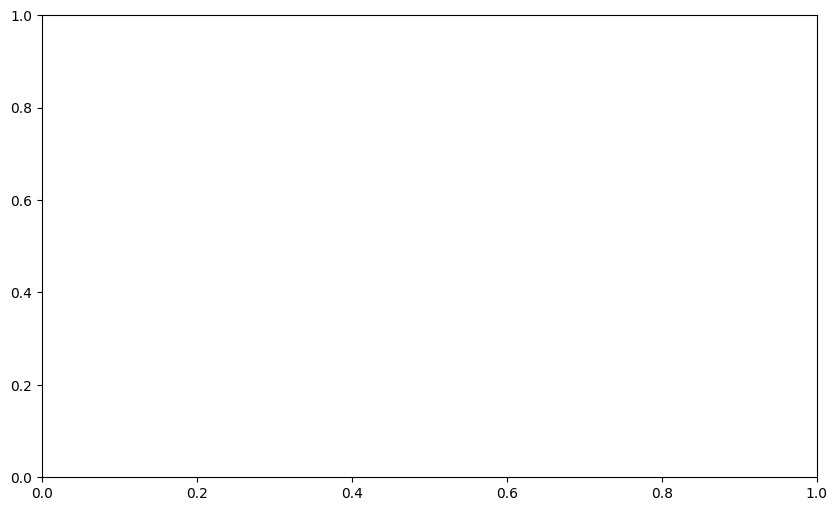

In [1]:
# from shiny import App, render, ui, reactive

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import statsmodels.api as sm
import os


path = 'C:/Users/Janet/OneDrive - The University of Chicago/Data_policy/final-project-janet'
file_name = 'combined_stock_data.csv'
file_path = os.path.join(path, file_name)
df = pd.read_csv(file_path)

def calculate_stock_and_market_return(data):
    data['stock_return'] = data.groupby('ticker')['stock_adj_close'].pct_change()
    data['market_return'] = data['market_adj_close'].pct_change()
    return data

def estimate_parameters(ticker, data):
    stock_data = data[data['ticker'] == ticker].dropna()
    if len(stock_data) < 2: 
        return np.nan, np.nan
    
    # Ensure that 'market_return' exists in stock_data
    if 'market_return' not in stock_data.columns:
        raise KeyError("Column 'market_return' not found in stock_data.")

    # Adding a constant to the independent variable for OLS regression
    X = sm.add_constant(stock_data['market_return'])

    model = sm.OLS(stock_data['stock_return'], X).fit()
    return model.params



def calculate_expected_return(row, params):
    alpha, beta = params.get(row['ticker'], (np.nan, np.nan))
    if pd.isna(alpha) or pd.isna(beta):  
        return np.nan
    return alpha + beta * row['market_return']

def calculate_abnormal_return(group_data, parameters):
    group_data['expected_return'] = group_data.apply(lambda row: calculate_expected_return(row, parameters), axis=1)
    group_data['abnormal_return'] = group_data['stock_return'] - group_data['expected_return']
    return group_data

def calculate_volume_difference(group_data, group_estimation_data):
    average_volume_estimation = group_estimation_data.groupby('ticker')['stock_volume'].mean()
    group_data = group_data.join(average_volume_estimation, on='ticker', rsuffix='_avg')
    group_data['volume_difference'] = group_data['stock_volume'] - group_data['stock_volume_avg']
    return group_data


def grouped_event_study(data, study_type, event_date, group_by, window_size=10, estimation_window_size=30):
    start_date = event_date - timedelta(days=window_size)
    end_date = event_date + timedelta(days=window_size)
    estimation_start_date = start_date - timedelta(days=estimation_window_size)
    estimation_end_date = start_date - timedelta(days=1)

    grouped_event_data = {}
    for group in data[group_by].unique():
        group_data = data[(data['date'] >= start_date) & (data['date'] <= end_date) & (data[group_by] == group)].copy()
        group_estimation_data = data[(data['date'] >= estimation_start_date) & (data['date'] <= estimation_end_date) & (data[group_by] == group)].copy()

        if group_data.empty:
            continue

        if study_type == 'price':
            parameters = {ticker: estimate_parameters(ticker, group_data) for ticker in group_data['ticker'].unique()}
            group_data = calculate_abnormal_return(group_data, parameters)

        elif study_type == 'volume':
            group_data = calculate_volume_difference(group_data, group_estimation_data)

        grouped_event_data[group] = group_data

    return grouped_event_data




def plot_grouped_event_study(grouped_data, study_type, event_date, group_by):
    column = 'volume_difference' if study_type == 'volume' else 'abnormal_return'

    # Create figure and axes using plt.subplots()
    fig, ax = plt.subplots(figsize=(15, 6) if study_type == 'volume' else (10, 6))

    # Define sector names for nicer labeling
    sector_names = {'businessConsumer_services': 'Business Consumer Services',
                    'technology': 'Technology'}

    for group, group_data in grouped_data.items():
        # Convert the dates to a number format and find the relative date difference
        group_data['date_num'] = mdates.date2num(pd.to_datetime(group_data['date']))
        event_date_num = mdates.date2num(event_date)
        group_data['days_from_event'] = (group_data['date_num'] - event_date_num).round()

        mean_data = group_data.groupby('days_from_event')[column].mean().to_frame('mean')

        label = sector_names.get(group, group) if group_by == 'sector' else group

        # Plot the data on the axes object
        sns.lineplot(data=mean_data, x=mean_data.index, y='mean', marker='o', label=label, ax=ax)

    ax.axhline(0, color='grey', linestyle='--')
    ax.axvline(0, color='red', lw=1, ls='--')  # Zero now represents the event date
    ax.set_title(f'Average {("Abnormal Returns" if study_type == "price" else "Volume Difference")} across {group_by.capitalize()} around the CCPA Signing')
    ax.set_xlabel('Days from CCPA Signing')
    ax.set_ylabel(f'Average {("Abnormal Return" if study_type == "price" else "Volume Difference")}')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title=group_by.capitalize())
    plt.tight_layout()

    return ax
stock_data = pd.read_csv('combined_stock_data.csv')

stock_data['date'] = pd.to_datetime(stock_data['date'])

event_date = datetime(2018, 6, 28)
group_by = 'exchange'
study_type = 'Volume'

# Ensure the 'date' column is of datetime type in your DataFrame
stock_data = calculate_stock_and_market_return(stock_data)

grouped_price_event_data = grouped_event_study(stock_data, study_type, event_date, group_by)
plot_grouped_event_study(grouped_price_event_data, study_type, event_date, group_by)


In [ ]:
from shiny import App, render, ui, reactive
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import statsmodels.api as sm

# from analysis import (
#     calculate_stock_and_market_return,
#     estimate_parameters,
#     calculate_expected_return,
#     calculate_abnormal_return,
#     calculate_volume_difference,
# )


app_ui = ui.page_fluid(
    ui.row(
        ui.column(4, ui.output_image(id='logo'), style="padding-bottom:0px; margin-bottom:-250px"),
        ui.column(4, 
                  ui.h1('Yingying Cao Final Project'), 
                  ui.hr()),
        ui.column(4, 
                  ui.h1('PPHA 30538 Autumn 2023'),
                  ui.hr())
    ),
        ui.row(
        ui.column(6, 
                  ui.input_select(id='xaxis', 
                                  label='Please select the x ', 
                                  choices=['Industry', 'Exchange'])),
        ui.column(6, 
                  ui.input_select(id='yaxis', 
                                  label='Please select the y', 
                                  choices=['Stock Price', 'Market Capitalization', 'Volume']))
        ),
    #     ui.row(
    #     ui.column(6, 
    #               ui.output_text('text'),
    #     offset=6)
    # ),
    ui.row(
        ui.column(12, 
                  ui.output_plot('plot1'), 
                  align='center')
    ),
    ui.row(
        ui.column(6, 
                  ui.input_select(id='aspect', 
                                  label='Please select the aspect of event study you want to focus on: ', 
                                  choices=['Stock Price','Volume'])),
        ui.column(6, 
                  ui.input_select(id='categorize', 
                                  label='How do you want to categorize them?', 
                                  choices=['Exchange', 'Sector']))
    ),
    ui.row(
        ui.column(12, 
                  ui.output_plot('plot2'), 
                  align='center')
    )
)



def server(input, output, session):
    # @reactive.Calc
    # def get_data():
    #     df = pd.read_csv('combined_stock_data.csv')
        
    #     return df[df['Year'] == int(input.year())]
    
    @output
    @render.image
    def logo():
        return {
            'src': "my_app/harris_logo.png",
            'width': '300',  
            'height': 'auto'  
        }
        
    # @output
    # @render.text
    # def text():
    #     text_year = int(input.year())
    #     if text_year == 2005:
    #         return "The selected year is a BRAC year"
    #     else:
    #         return "The selected year is not a BRAC year"


    @output
    @render.plot
    def plot1(log_scale='auto'):

        df = pd.read_csv('combined_stock_data.csv')
        
        x_axis_input = input.xaxis()
        y_axis_input = input.yaxis()

        # Mapping of user-friendly input values to DataFrame column names
        input_to_column = {
            'Stock Price': 'stock_adj_close',
            'Market Capitalization': 'stock_market_cap',
            'Volume': 'stock_volume',
            'Industry': 'industry',
            'Exchange': 'exchange'
        }

        x_axis = input_to_column.get(x_axis_input, x_axis_input)
        y_axis = input_to_column.get(y_axis_input, y_axis_input)
        hue = 'sector' if x_axis_input == 'Industry' else None


        palette_column = hue if x_axis_input == 'Industry' else x_axis
        palette = sns.color_palette("pastel", len(df[palette_column].unique()))
        palette = dict(zip(df[palette_column].unique(), palette))

        
        plt.figure(figsize=(15, 8))
        ax = sns.boxplot(x=x_axis, y=y_axis, hue=hue, data=df, palette=palette, dodge=False,showfliers=False)
        if x_axis_input == 'Industry': # Format the x-axis labels to be more readable
            ax.set_xticklabels([label.get_text().replace('_', ' ').title() for label in ax.get_xticklabels()])
        
        plt.title(f'Box-and-Whisker Plot of {y_axis_input.capitalize()} by {x_axis_input.capitalize()}')
        plt.ylabel(y_axis_input.capitalize())
        plt.xlabel(x_axis_input.capitalize())
        ax.xaxis.grid(False) # unfinished
        ax.yaxis.grid(True)
        plt.xticks(rotation=65)
        
        # Automatically determine y-axis scale for readability
        if log_scale == 'auto':
            if df[y_axis].min() > 0: 
                data_range = np.log10(df[y_axis].max()) - np.log10(df[y_axis].min())
                if data_range > 3:  # Use a log scale if data range is large
                    ax.set_yscale('log')
            else:
                # Add a small constant to zero values if present to use log scale
                df[y_axis] += df[y_axis].eq(0)
                ax.set_yscale('log')
                ax.set_ylim(bottom=1)  # Set the bottom of the y-axis to 1 to avoid negative values
        elif log_scale:
            ax.set_yscale('log')

        if df[y_axis].max() < 10000:
            ax.ticklabel_format(style='plain', axis='y')
            
        if hue:
            plt.legend(title=hue.capitalize())
    
        return ax
    
    @output
    @render.plot
    def plot2():
        input_study_type = input.aspect()
        input_group_by = input.categorize()

        # Mapping of user-friendly input values to DataFrame column names
        input_to_column = {
            'Stock Price': 'price',
            'Volume': 'volume',
            'Sector': 'sector',
            'Exchange': 'exchange'
        }

        study_type = input_to_column.get(input_study_type, input_study_type)
        group_by = input_to_column.get(input_group_by, input_group_by)

        def calculate_stock_and_market_return(data):
            data['stock_return'] = data.groupby('ticker')['stock_adj_close'].pct_change()
            data['market_return'] = data['market_adj_close'].pct_change()
            return data

        def estimate_parameters(ticker, data):
            stock_data = data[data['ticker'] == ticker].dropna()
            if len(stock_data) < 2: 
                return np.nan, np.nan
            
            # Ensure that 'market_return' exists in stock_data
            if 'market_return' not in stock_data.columns:
                raise KeyError("Column 'market_return' not found in stock_data.")

            # Adding a constant to the independent variable for OLS regression
            X = sm.add_constant(stock_data['market_return'])

            model = sm.OLS(stock_data['stock_return'], X).fit()
            return model.params



        def calculate_expected_return(row, params):
            alpha, beta = params.get(row['ticker'], (np.nan, np.nan))
            if pd.isna(alpha) or pd.isna(beta):  
                return np.nan
            return alpha + beta * row['market_return']

        def calculate_abnormal_return(group_data, parameters):
            group_data['expected_return'] = group_data.apply(lambda row: calculate_expected_return(row, parameters), axis=1)
            group_data['abnormal_return'] = group_data['stock_return'] - group_data['expected_return']
            return group_data

        def calculate_volume_difference(group_data, group_estimation_data):
            average_volume_estimation = group_estimation_data.groupby('ticker')['stock_volume'].mean()
            group_data = group_data.join(average_volume_estimation, on='ticker', rsuffix='_avg')
            group_data['volume_difference'] = group_data['stock_volume'] - group_data['stock_volume_avg']
            return group_data


        def grouped_event_study(data, study_type, event_date, group_by, window_size=10, estimation_window_size=30):
            start_date = event_date - timedelta(days=window_size)
            end_date = event_date + timedelta(days=window_size)
            estimation_start_date = start_date - timedelta(days=estimation_window_size)
            estimation_end_date = start_date - timedelta(days=1)

            grouped_event_data = {}
            for group in data[group_by].unique():
                group_data = data[(data['date'] >= start_date) & (data['date'] <= end_date) & (data[group_by] == group)].copy()
                group_estimation_data = data[(data['date'] >= estimation_start_date) & (data['date'] <= estimation_end_date) & (data[group_by] == group)].copy()

                if group_data.empty:
                    continue

                if study_type == 'price':
                    parameters = {ticker: estimate_parameters(ticker, group_data) for ticker in group_data['ticker'].unique()}
                    group_data = calculate_abnormal_return(group_data, parameters)

                elif study_type == 'volume':
                    group_data = calculate_volume_difference(group_data, group_estimation_data)

                grouped_event_data[group] = group_data

            return grouped_event_data




        def plot_grouped_event_study(grouped_data, study_type, event_date, group_by):
            column = 'volume_difference' if study_type == 'volume' else 'abnormal_return'

            # Create figure and axes using plt.subplots()
            fig, ax = plt.subplots(figsize=(15, 6) if study_type == 'volume' else (10, 6))

            # Define sector names for nicer labeling
            sector_names = {'businessConsumer_services': 'Business Consumer Services',
                            'technology': 'Technology'}

            for group, group_data in grouped_data.items():
                # Convert the dates to a number format and find the relative date difference
                group_data['date_num'] = mdates.date2num(pd.to_datetime(group_data['date']))
                event_date_num = mdates.date2num(event_date)
                group_data['days_from_event'] = (group_data['date_num'] - event_date_num).round()

                mean_data = group_data.groupby('days_from_event')[column].mean().to_frame('mean')

                label = sector_names.get(group, group) if group_by == 'sector' else group

                # Plot the data on the axes object
                sns.lineplot(data=mean_data, x=mean_data.index, y='mean', marker='o', label=label, ax=ax)

            ax.axhline(0, color='grey', linestyle='--')
            ax.axvline(0, color='red', lw=1, ls='--')  # Zero now represents the event date
            ax.set_title(f'Average {("Abnormal Returns" if study_type == "price" else "Volume Difference")} across {group_by.capitalize()} around the CCPA Signing')
            ax.set_xlabel('Days from CCPA Signing')
            ax.set_ylabel(f'Average {("Abnormal Return" if study_type == "price" else "Volume Difference")}')
            ax.tick_params(axis='x', rotation=45)
            ax.legend(title=group_by.capitalize())
            plt.tight_layout()

            return ax
        stock_data = pd.read_csv('combined_stock_data.csv')

        stock_data['date'] = pd.to_datetime(stock_data['date'])

        event_date = datetime(2018, 6, 28)
        # group_by = 'exchange'
        # study_type = 'price'

        # Ensure the 'date' column is of datetime type in your DataFrame
        stock_data = calculate_stock_and_market_return(stock_data)

        grouped_price_event_data = grouped_event_study(stock_data, study_type, event_date, group_by)
        plot_grouped_event_study(grouped_price_event_data, study_type, event_date, group_by)
                




app = App(app_ui, server)

